# Inbalanced Classes
## In this lab, we are going to explore a case of imbalanced classes. 


Like we disussed in class, when we have noisy data, if we are not careful, we can end up fitting our model to the noise in the data and not the 'signal'-- the factors that actually determine the outcome. This is called overfitting, and results in good results in training, and in bad results when the model is applied to real data. Similarly, we could have a model that is too simplistic to accurately model the signal. This produces a model that doesnt work well (ever). 


### First, download the data from: https://www.kaggle.com/ntnu-testimon/paysim1. Import the dataset and provide some discriptive statistics and plots. What do you think will be the important features in determining the outcome?

In [1]:
# imports

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from imblearn.combine import SMOTETomek

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report


In [2]:
# Your code here
paysim = pd.read_csv("../PS_20174392719_1491204439457_log.csv")

In [3]:
# Metadata
"""

- step: maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).
- type: CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.
- amount: amount of the transaction in local currency.
- nameOrig: customer who started the transaction
- oldbalanceOrg: initial balance before the transaction
- newbalanceOrig: new balance after the transaction
- nameDest: customer who is the recipient of the transaction
- oldbalanceDest: initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).
- newbalanceDest: new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).
- isFraud: This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.
- isFlaggedFraud: The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

"""

'\n\n- step: maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).\n- type: CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.\n- amount: amount of the transaction in local currency.\n- nameOrig: customer who started the transaction\n- oldbalanceOrg: initial balance before the transaction\n- newbalanceOrig: new balance after the transaction\n- nameDest: customer who is the recipient of the transaction\n- oldbalanceDest: initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).\n- newbalanceDest: new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).\n- isFraud: This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by trans

In [4]:
paysim.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [5]:
paysim.dtypes

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

In [6]:
paysim.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [7]:
paysim.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [8]:
paysim.type.value_counts()

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64

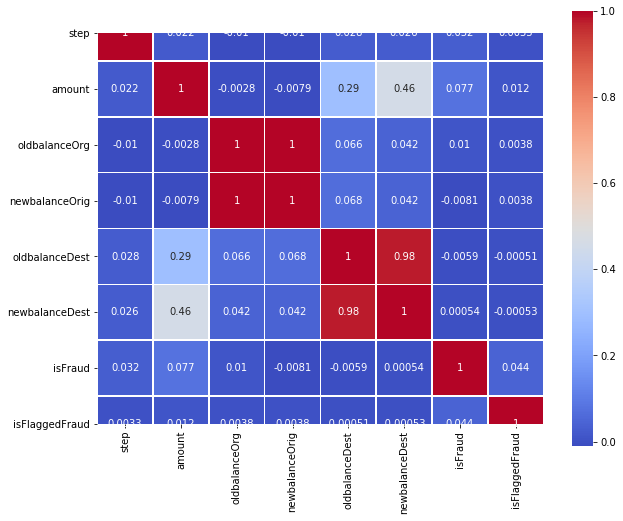

In [9]:
plt.figure(figsize=(10,8))
sns.heatmap(paysim.corr(),vmax=1, square=True, cmap="coolwarm", linewidths=.5, annot=True);

I think the **most important features will be amount**
And, **type might help us on the way** - it will need to be converted to num varibale with get dummies.

Last but not list, oldbalanceDest & newbalanceDest should be remove as they are no bringind info (we already have amount to see what was moved) and they are bringin colliniarity.

### What is the distribution of the outcome? 

In [10]:
# Your response here
paysim['isFraud'].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

### Clean the dataset. How are you going to integrate the time variable? Do you think the step (integer) coding in which it is given is appropriate?

**1. Clean columns (removing not important columns)**

In [11]:
# Your code here

# Creat new dataset with type == 'TRANSFER'| 'CASH_OUT' as they are the ones more corr with Fraud
paysim_clean = paysim.loc[(paysim.type == 'TRANSFER') | (paysim.type == 'CASH_OUT')]

# As commented before, the column type might help us, but first we need to get dummies 
paysim_clean = pd.get_dummies(paysim_clean, columns=['type'], drop_first=True)

# As commented before, 'oldbalanceOrg'and 'newbalanceOrig', 'oldbalanceDest' are bringin colliniarity and no new info
paysim_clean.drop(columns=['nameOrig', 'nameDest', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest'], inplace=True)


In [12]:
paysim_clean.head()

,step,amount,newbalanceDest,isFraud,isFlaggedFraud,type_TRANSFER
2,1,181.00,0.00,1,0,1
3,1,181.00,0.00,1,0,0
15,1,229133.94,51513.44,0,0,0
19,1,215310.30,0.00,0,0,1
24,1,311685.89,2719172.89,0,0,1


**2. Adding extra 'Time' column**

In [13]:
# Below that code fom kaggle that was interesting to add about timing & nice to keep

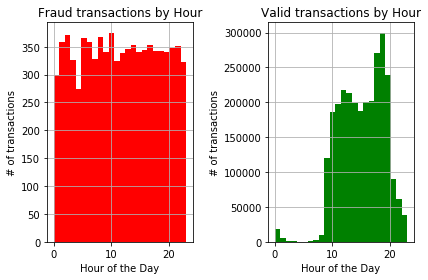

In [14]:
# Step: every step is 1h and there are 743 steps for 30 days of data. I'm going to
# convert them into 24h to check if there is a pattern in the hours when the fraud
# is more likely to happen

# getting hours and days of the week
num_days = 7
num_hours = 24
fraud_days = paysim_clean[paysim_clean['isFraud']==1].step % num_days
fraud_hours = paysim_clean[paysim_clean['isFraud']==1].step % num_hours
valid_days = paysim_clean[paysim_clean['isFraud']==0].step % num_days
valid_hours = paysim_clean[paysim_clean['isFraud']==0].step % num_hours

# visualize Fraud transactions by Hour
plt.subplot(1, 2, 1)
fraud_hours.hist(bins=num_hours, color="red")
plt.title('Fraud transactions by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel("# of transactions")

# visualize Valid transactions by Hour
plt.subplot(1, 2, 2)
valid_hours.hist(bins=num_hours, color="green")
plt.title('Valid transactions by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel("# of transactions")

plt.tight_layout()
plt.show()

In [15]:
paysim_clean['hour'] = paysim_clean['step']%24

In [16]:
paysim_clean.head()

,step,amount,newbalanceDest,isFraud,isFlaggedFraud,type_TRANSFER,hour
2,1,181.00,0.00,1,0,1,1
3,1,181.00,0.00,1,0,0,1
15,1,229133.94,51513.44,0,0,0,1
19,1,215310.30,0.00,0,0,1,1
24,1,311685.89,2719172.89,0,0,1,1


**3. Balance data**

As data us unbalence we will use SMOTETomek to try to balance it

In [17]:
stomek = SMOTETomek ()

In [18]:
stomek = SMOTETomek ()

X= paysim_clean.drop('isFraud', axis=1)
y= paysim_clean['isFraud']

X_stomek, y_stomek = stomek.fit_resample(X, y)

In [19]:
print(X_stomek.shape)
print(y_stomek.shape)

(5436996, 6)
(5436996,)


**4. Check correlation**

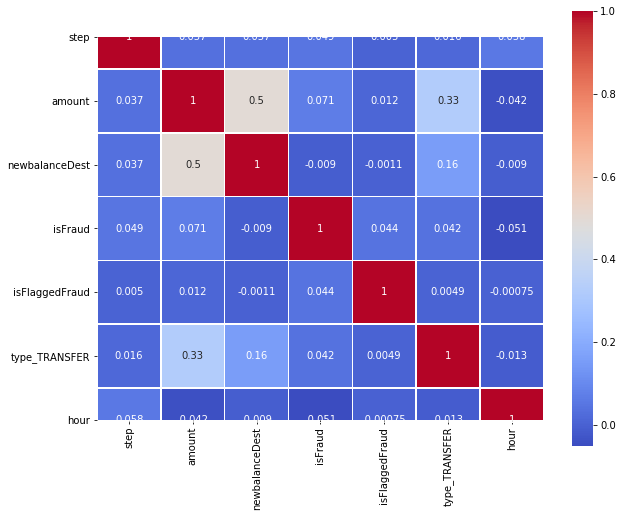

In [20]:
plt.figure(figsize=(10,8))
sns.heatmap(paysim_clean.corr(),vmax=1, square=True, cmap="coolwarm", linewidths=.5, annot=True);

### Run a logisitc regression classifier and evaluate its accuracy.

In [21]:
# Your code here

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size=0.2)
X_train_stomek, X_test_stomek, y_train_stomek, y_test_stomek = train_test_split(X_stomek, y_stomek,random_state=42, test_size=0.2)


**Unbalance data**

In [22]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.9973505726589206

In [23]:
y_pred = lr.predict(X_test)

In [24]:
# Accuracy
accuracy_score(y_test, y_pred)

0.9973505726589206

In [25]:
# Classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552436
           1       0.79      0.15      0.25      1646

    accuracy                           1.00    554082
   macro avg       0.89      0.57      0.62    554082
weighted avg       1.00      1.00      1.00    554082



**Balance data**

In [26]:
lr = LogisticRegression()
lr.fit(X_train_stomek, y_train_stomek)
lr.score(X_test_stomek, y_test_stomek)

0.7485561890748574

In [27]:
y_stomek_pred = lr.predict(X_test_stomek)

In [28]:
# Accuracy
accuracy_score(y_test_stomek, y_stomek_pred)

0.7485561890748574

In [29]:
# Classification report
print(classification_report(y_test_stomek, y_stomek_pred))

              precision    recall  f1-score   support

           0       0.82      0.64      0.72    543874
           1       0.70      0.86      0.77    543526

    accuracy                           0.75   1087400
   macro avg       0.76      0.75      0.75   1087400
weighted avg       0.76      0.75      0.75   1087400



In [30]:
"""
After balancing data we see that accurancy overall does not imprive but we se that 1 has now a better recall.
For this data set we'll preser the data balanced, as those re the fraudulent bank moves.
"""

"\nAfter balancing data we see that accurancy overall does not imprive but we se that 1 has now a better recall.\nFor this data set we'll preser the data balanced, as those re the fraudulent bank moves.\n"

### Now pick a model of your choice and evaluate its accuracy.

Let's check it with the Random Forest Classifier


**Unbalance data**

In [31]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

RandomForestClassifier()

In [32]:
rfc.score(X_test, y_test)

0.9991355070188167

In [33]:
y_pred = rfc.predict(X_test)

In [34]:
# Accuracy
accuracy_score(y_test, y_pred)

0.9991355070188167

In [35]:
# Classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552436
           1       0.94      0.76      0.84      1646

    accuracy                           1.00    554082
   macro avg       0.97      0.88      0.92    554082
weighted avg       1.00      1.00      1.00    554082



#### Balance data

In [36]:
rfc = RandomForestClassifier()
rfc.fit(X_train_stomek, y_train_stomek)
rfc.score(X_test_stomek, y_test_stomek)

0.9965707191465882

In [37]:
y_stomek_pred = rfc.predict(X_test_stomek)

In [38]:
# Accuracy
accuracy_score(y_test_stomek, y_stomek_pred)

0.9965707191465882

In [39]:
# Classification report
print(classification_report(y_test_stomek, y_stomek_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    543874
           1       1.00      1.00      1.00    543526

    accuracy                           1.00   1087400
   macro avg       1.00      1.00      1.00   1087400
weighted avg       1.00      1.00      1.00   1087400



### Which model worked better and how do you know?

In [40]:
# Your response here
"""
The better model is RFC after having balance the data with stomek. Nevetheless, 100% looks too good to be true.
"""

' '